# Random Forest Classifier
## Offshore Inc.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_de = pd.read_csv('D:\\OneDrive\\Vassar\\DataFest\\data\\DE\\de.csv', parse_dates=['DATE'])
df_ca = pd.read_csv('D:\\OneDrive\\Vassar\\DataFest\\data\\CA\\ca.csv', parse_dates=['DATE'])
df_uk = pd.read_csv('D:\\OneDrive\\Vassar\\DataFest\\data\\UK\\uk.csv', parse_dates=['DATE'])
df_us = pd.read_csv('D:\\OneDrive\\Vassar\\DataFest\\data\\US\\US\\us18.csv', parse_dates=['DATE'])

## 1. Data cleaning + feature engineering

In [4]:
def get_drug_names(df, country):
    # returns a list of drug names for convenience
    if country == 'de':
        i = 14
    elif country == 'ca':
        i = 16
    elif country == 'uk':
        i = 19
    elif country == 'us':
        i = 17
    
    drugs = [x for x in df.columns if 'NMU' in x][:i]
    drugs = [x.split('_')[0] for x in drugs]

    if country == 'ca':
        drugs.remove('COTC')
    elif country == 'uk':
        drugs.remove('DOTC')

    return drugs

In [5]:
def get_use_cat(df, country):
    # make new df so old dataset is not affected
    new_df = df.copy()
    # get list of drug names
    drugs = get_drug_names(df, country)
    # make categorical variable for each drug
    for drug in drugs:
        new_df[f'{drug}_USE_CAT'] = new_df[f'{drug}_USE'] + new_df[f'{drug}_NMU']
        new_df[f'{drug}_USE_CAT'].fillna(value=0, inplace=True)
    # in the returned df, each drug now has a column indicating how the correspondent uses the drug
    # 0 -> never used
    # 1 -> used for prescription purposes
    # 2 -> used for recreational purposes
    return new_df

In [6]:
def calculate_proportions(df, country):
    new_df = get_use_cat(df)
    drugs = get_drug_names(df, country)
    # empty dict to insert values
    d = {}
    # for each drug, get proportions of recreational use
    for drug in drugs:
        # get number of people for prescription and recreational purposes
        num_pre = new_df[f'{drug}_USE_CAT'].value_counts().loc[1.0]
        num_rec = new_df[f'{drug}_USE_CAT'].value_counts().loc[2.0]
        # get percentage of recreational usage
        percentage = num_rec / (num_pre + num_rec)
        # insert into dictionary
        d[drug] = percentage
    return d

In [7]:
def get_recr_use(df, country):
    # this function returns a list indicating NMU of one or more drugs
    df_new = df.copy()
    drugs = get_drug_names(df_new, country)
    use_cat = [x+'_USE_CAT' for x in drugs]
    RECR_USE = []
    # loop thru df,
    # if at least one drug has been used for recreational purposes, mark True
    for i in range(len(df)):
        recr_use = 0
        for drug in use_cat:
            if df_new.at[i, drug] == 2.0:
                recr_use = 1
                break
        RECR_USE.append(recr_use)
    return RECR_USE

In [8]:
def got_pres_for_pain(df):
    # this function returns a list indicating if a person has received prescription for pain
    df_new = df.copy()
    PRES_FOR_PAIN = []
    for i in range(len(df_new)):
        # Have the patient received prescription for chronic or acute pain?
        PAIN_CHRONIC_RX = df_new.at[i, 'PAIN_CHRONIC_RX']
        PAIN_ACUTE_RX = df_new.at[i, 'PAIN_ACUTE_RX']
        PRES_FOR_PAIN.append(pd.notna(PAIN_CHRONIC_RX) or pd.notna(PAIN_ACUTE_RX))
        PRES_FOR_PAIN = [1 if x else 0 for x in PRES_FOR_PAIN]
    return PRES_FOR_PAIN

In [9]:
def get_illicit_use(df, country):
    # this function returns a list indicating if a person has used illicit drugs in the past
    df_new = df.copy()
    # list all illicit drugs
    if country == 'de':
        illicit = ['CAN_USE','COKE_USE','CRACK_USE','MDMA_USE','SPEED_USE','GHB_USE','HEROIN_USE','KET_USE','LEGAL_USE','LSD_USE','MUSH_USE','STER_USE','NPFENT_USE','INH_USE','MEPH_USE']
    elif country == 'ca':
        illicit = ['CAN_REC_USE','CAN_MED_USE','CAN_USE','COKE_USE','CRACK_USE','MDMA_USE','GHB_USE','HAL_USE','INH_USE','SPEED_USE','NPFENT_USE','HEROIN_USE','KET_USE','MEPH_USE','SPICE_USE','SAL_USE','STER_USE']
    elif country == 'uk':        
        illicit = ['CAN_USE','COKE_USE','CRACK_USE','MDMA_USE','GHB_USE','SPEED_USE','NPFENT_USE','HEROIN_USE','KET_USE','MEPH_USE','METHAM_USE','LSD_USE','MUSH_USE','POP_USE','STER_USE','KHAT_USE','SPICE_USE','SAL_USE']
    elif country == 'us':
        illicit = ['CAN_USE','COKE_USE','CRACK_USE','MDMA_USE','GHB_USE','INH_USE','SPEED_USE','METHAM_USE','NPFENT_USE','HEROIN_USE','KET_USE','MEPH_USE','LSD_USE','MUSH_USE','PCP_USE','MESC_USE','SPICE_USE','SAL_USE','STER_USE']

    ILLICIT_USE = []
    for i in range(len(df_new)):
        illicit_use = 0
        for drug in illicit:
            if df_new.at[i, drug] != 1:
                illicit_use = 1
                break
        ILLICIT_USE.append(illicit_use)
    return ILLICIT_USE

In [10]:
def get_mental_condition(df):
    # this function returns a list indicating if a person has mental conditions
    df_new = df.copy()
    MENTAL_COND = []
    for i in range(len(df_new)):
        if df_new.at[i, 'MENT_NONE'] == 1:
            MENTAL_COND.append(0)
        else:
            MENTAL_COND.append(1)
    return MENTAL_COND

In [11]:
def get_pres_predictors(df, country):
    # returns a df with columns containing prescripted drug use category
    df_use = get_use_cat(df, country)
    drugs = get_drug_names(df, country)
    pred_cols = [x+'_USE_CAT' for x in drugs]
    return df_use[pred_cols]

In [12]:
def get_belief(df):
    # do you believe prescription drugs are safer than illicit drugs in three categories
    df_belief = df.copy()
    df_belief['BELIEF'] = df_belief['RXDRUGSAFE_HIGH']*df_belief['RXDRUGSAFE_PAIN']*df_belief['RXDRUGSAFE_THER']
    return df_belief['BELIEF']

## 2. Get target variable
Target: Have this person misused a prescription drug?

In [13]:
def get_if_misused(df, country):
    df_new = df.copy()
    # get list of drug names
    drugs = get_drug_names(df, country)
    # make MISUSE variable for each drug
    for drug in drugs:
        df_new[f'{drug}_MISUSE'] = df_new[f'{drug}_NMU'].fillna(0)
        df_new[f'{drug}_MISUSE'] = df_new[f'{drug}_MISUSE'].astype(int)
    # added up all drug misuses
    df_new['TOTAL_MISUSE'] = 0
    for drug in drugs:
        df_new['TOTAL_MISUSE'] += df_new[f'{drug}_MISUSE']
    
    if_misused = [1 if x != 0 else 0 for x in df_new['TOTAL_MISUSE']]
    if_misused = pd.Series(if_misused, name='MISUSED')

    return if_misused

In [14]:
y = get_if_misused(df_de, 'de')

## 3. Get predictors

In [15]:
def get_predictors(df, country):
    # demographic predictors
    if country == 'us':
        X = df[['DEM_GENDER','DEM_AGE10','DEM_REGION','DEM_STDNT', 'DEM_MARITAL', 'DEM_EDU','DEM_VET','DEM_HEALTH','DEM_INCOME','HELP_SUB_USE']]        
    else:
        X = df[['DEM_GENDER','DEM_AGE10','DEM_LOCATION','DEM_STDNT', 'DEM_MARITAL', 'DEM_EDU','DEM_VET','DEM_HEALTH','DEM_INCOME','HELP_SUB_USE']]

    # add predictor for mental condition
    X['MENTAL_CON'] = get_mental_condition(df)
    # add predictor for illicit drug use
    X['ILLICIT'] = get_illicit_use(df, country)
    # add predictor for pain prescription
    X['PRES_FOR_PAIN'] = got_pres_for_pain(df)
    # add predictor for getting prescription from physician
    if country == 'ca' or country == 'uk':
        X['MISUSE_ATTEMPT'] = df['DRSHOP_NMU']        
    elif country == 'us' or country == 'de':
        X['MISUSE_ATTEMPT'] = df['DRSHOP_USE']
    X['MISUSE_SELL'] = df['DRSHOP_SELL']
    return X

In [16]:
X = get_predictors(df_de, 'de')

In [17]:
from sklearn.model_selection import train_test_split
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 4. Start training the mod... Wait
Let's take a closer look at the target variable of our training set and count them

Text(0.5, 1.0, 'NEVER MISUSED vs. MISUSED')

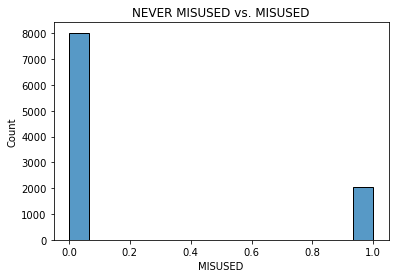

In [18]:
sns.histplot(data=pd.Series(y_train)).set_title('NEVER MISUSED vs. MISUSED')

There are too many people who never misused and too little people who did. This means our sample is an *imbalanced* sample.
Imagine an extremely simple model that always guesses "NEVER MISUSED" - it would have 80% accurancy.

## 5. Up-sampling
One way to deal with this is called *"up-sampling"*. We can randomly replicate the "minority" varible (MISUSED) until the number of observations equals to the "majority" variable.

First, divide up our training set into majority and minority sets according to the target variable.

In [19]:
def divide_train(X_train, y_train):
    # first put X and y back together
    df_combine = pd.concat([X_train, y_train], axis=1).rename(columns={0:'MISUSED'})
    # divide up values according to y
    df_majority = df_combine[df_combine['MISUSED'] == 0]
    df_minority = df_combine[df_combine['MISUSED'] == 1]
    return df_majority, df_minority

Then, randomly replicate the minority sample until the number of observations matches the majority sample.

In [20]:
from sklearn.utils import resample

In [21]:
def up_sample(df_tuple, cv_fold=10):
    df_majority, df_minority = df_tuple[0], df_tuple[1]
    # randomly split the minority set into the number of cv folds so data is not contaminated
    df_shuffled = df_minority.sample(frac=1)
    shuffled_list = np.array_split(df_shuffled, cv_fold)
    # now we have a list containing cv_fold number of elements, where elements are mutually-exclusive subsets of df_minority
    # print('shuffled_list is a              ', type(shuffled_list))
    # print('an element in shuffle_list is a ', type(shuffled_list[0]))
    # create an empty df
    df_upsampled = pd.DataFrame(columns=df_minority.columns)
    # each subset in shuffle_list should be upsampled to n = final_size / cv_fold
    final_size = len(df_majority)
    subset_size = int(final_size / cv_fold)
    # loop over the shuffled list and upsample each one
    for subset in shuffled_list:
        upsampled_subset = resample(subset, replace=True, n_samples=subset_size, random_state=123)
        df_upsampled = pd.concat([df_upsampled, upsampled_subset], axis=0, ignore_index=True)
    # now the minority set has the same size as the majority size
    print('\n[UPSAMPLED]')
    print(f'Length of majority set: {final_size}')
    print(f'Length of minority set: {len(df_upsampled)}')
    # combine majority and upsampled minority set and return it
    df_combined = pd.concat([df_majority, df_upsampled], axis=0, ignore_index=True)
    df_combined = df_combined.sample(frac=1).reset_index(drop=True)
    # return new X_train and y_train
    print('\nUpdated X_train and y_train.')
    return df_combined.drop(columns=['MISUSED']), df_combined['MISUSED']

In [22]:
X_train, y_train = up_sample(divide_train(X_train, y_train))


[UPSAMPLED]
Length of majority set: 8027
Length of minority set: 8020

Updated X_train and y_train.


## 6. Training + tuning
Now that we have produced a balanced dataset, we can start training.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [24]:
def get_cv_score(X_train, y_train, max_features='auto', max_depth=None, cv_fold=10):
    y_train = list(y_train)
    rfc = RandomForestClassifier(max_features=max_features, max_depth=max_depth)
    rfc.fit(X_train, y_train)
    cv_score = cross_val_score(rfc, X_train, y_train, scoring='f1' ,cv=cv_fold).mean()
    return cv_score

In [25]:
def locate_optimal_max_feature(X_train, y_train):
    for i in np.arange(2, X_train.shape[1]):
        score = get_cv_score(X_train, y_train, max_features=i)
        print(f'Max Features: {i} -> {round(score*100, 5)}%')

In [26]:
locate_optimal_max_feature(X_train, y_train)

Max Features: 2 -> 91.75665%
Max Features: 3 -> 91.78263%
Max Features: 4 -> 91.6265%
Max Features: 5 -> 91.67009%
Max Features: 6 -> 91.5616%
Max Features: 7 -> 91.59826%
Max Features: 8 -> 91.36127%
Max Features: 9 -> 91.36009%
Max Features: 10 -> 91.16921%
Max Features: 11 -> 91.08469%
Max Features: 12 -> 91.2571%
Max Features: 13 -> 90.94881%
Max Features: 14 -> 90.97933%


Looks like there are no significant differences across max_feature levels. Let's stick with the default then.

In [27]:
def locate_optimal_max_depth(X_train, y_train):
    max_depth = np.arange(2, 25)
    cv_scores = []
    for i in max_depth:
        cv_scores.append(get_cv_score(X_train, y_train, max_depth=i))
    sns.lineplot(max_depth, cv_scores)

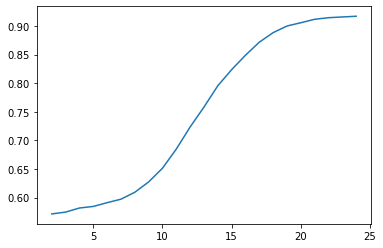

In [28]:
locate_optimal_max_depth(X_train, y_train)

Note that our cross validation core plateaus at around 20. We will use 20 for max_depth.

## 7. Test for accurancy

In [29]:
rfc = RandomForestClassifier(max_features='auto', max_depth=20)
rfc.fit(X_train, list(y_train))

RandomForestClassifier(max_depth=20)

In [30]:
X_pred = rfc.predict(X_test)
print(f'Accuracy: {round(sum(y_test == X_pred)/len(X_test)*100, 4)}%')

Accuracy: 72.8206%


Text(0.5, 1.0, 'Feature Importance')

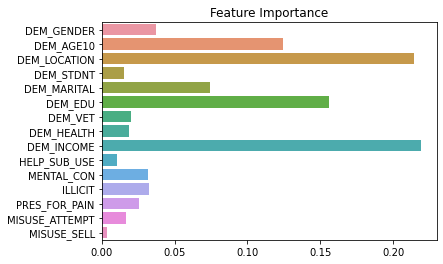

In [31]:
sns.barplot(x=rfc.feature_importances_, y=X_train.columns).set_title('Feature Importance')

## 8. What about other countries?
### Say we want to test our model out of sample... like *really* out of sample.

In [32]:
def test_on_country(country):
    if country == 'de':
        df = df_de
    elif country == 'ca':
        df = df_ca
    elif country == 'uk':
        df = df_uk
    elif country == 'us':
        df = df_us
    y = get_if_misused(df, country)
    X = get_predictors(df, country)
    X_pred = rfc.predict(X)
    print(f'Accuracy: {round(sum(y == X_pred)/len(y)*100, 4)}%')

In [33]:
for country in ['ca', 'uk', 'us']:
    print('\n', country.upper())
    test_on_country(country)


 CA
Accuracy: 75.1774%

 UK
Accuracy: 61.0334%

 US
Accuracy: 80.2313%


### If we wanted to see feature_importance for each country, we can train a model for each country.

In [34]:
def train_model(model, country):
    # put everything into one function for convenience
    if country == 'de':
        df = df_de
    elif country == 'ca':
        df = df_ca
    elif country == 'uk':
        df = df_uk
    elif country == 'us':
        df = df_us
    
    print(f'\n{country.upper()}\n-----------------')
    # first, get target variable and predictors
    y = get_if_misused(df, country)
    X = get_predictors(df, country)
    # split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    # upsample
    X_train, y_train = up_sample(divide_train(X_train, y_train))
    # make model
    model.fit(X_train, list(y_train))
    # test model
    X_pred = model.predict(X_test)
    print(f'Accuracy: {round(sum(y_test == X_pred)/len(X_test)*100, 4)}%')
    # plot importance
    sns.barplot(x=model.feature_importances_, y=X_train.columns).set_title(f'{country.upper()}: Feature Importance')


CA
-----------------

[UPSAMPLED]
Length of majority set: 5192
Length of minority set: 5190

Updated X_train and y_train.
Accuracy: 73.3878%


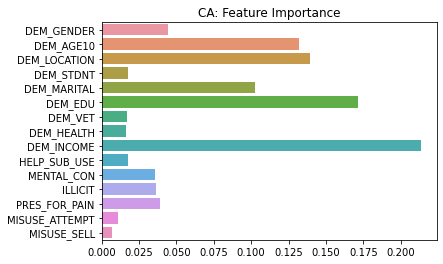

In [36]:
train_model(rfc, 'ca')


UK
-----------------

[UPSAMPLED]
Length of majority set: 4027
Length of minority set: 4020

Updated X_train and y_train.
Accuracy: 61.3568%


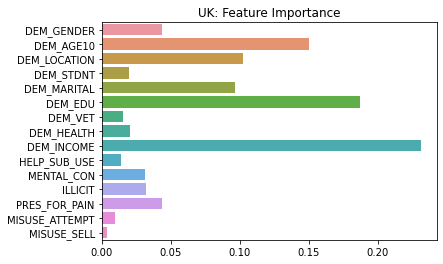

In [37]:
train_model(rfc, 'uk')


US
-----------------

[UPSAMPLED]
Length of majority set: 16693
Length of minority set: 16690

Updated X_train and y_train.
Accuracy: 79.8344%


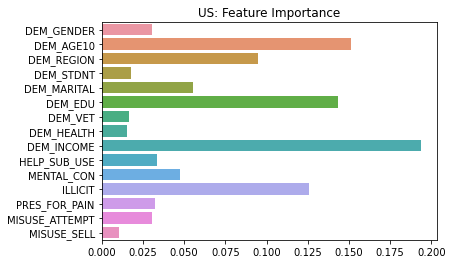

In [36]:
train_model(rfc, 'us')